1. Create conda env with GPU
2. Create data generator with augmentation
3. Create simple model
4. create advanced model with Bayesian Optimization for Hyperparameter tuning

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
import glob
%reload_ext autoreload
%autoreload 2



In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [23]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 960528230496385992,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9883877376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5547680197840193138
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [24]:
NUM_CLASSES = 34
IMAGE_SIZE = (256, 256, 3)
BATCH_SIZE = 18

In [25]:
def display_batch_of_images(batch):
  import matplotlib.pyplot as plt

  for i in range(len(batch[0])):

    image = batch[0][i]

    # normalize to [0,1]
    image =  (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-9)

    segmentation = tf.math.argmax(batch[1][i], axis=-1) # undo to_categorical

    segmentation = tf.cast(segmentation, tf.float32)
    segmentation = tf.multiply((255.0 / NUM_CLASSES), segmentation)
    segmentation = segmentation / 255.0

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation, vmin=0, vmax=1)
    plt.title('Ground Truth Segmentation')

    plt.show()

In [26]:
DATA_FOLDER = f"data"

In [27]:
import albumentations as A
from data_generator import SegmentationDataGenerator

aug = A.Compose([
        A.VerticalFlip(p=0.5),              
        A.RandomRotate90(p=0.5),
        A.PixelDropout(p=0.01),
        A.OneOf([
            A.MotionBlur(p=0.6),
            A.Blur(p=0.4),
        ], p=0.6),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.75),
        A.OpticalDistortion(p=0.3),
        #A.GridDistortion(p=0.3),
        A.RandomBrightnessContrast(p=0.5)
    ]
)

train_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/train/train2/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/train/train2/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = aug
)
train_data_gen = train_data.get_data_generator()

val_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/val/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/val/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = False
)
val_data_gen = val_data.get_data_generator()

Indexing Image files...
Indexing Segmentation files...
Loaded 23520 images with 23520 segmentations
Indexing Image files...
Indexing Segmentation files...
Loaded 8544 images with 8544 segmentations


# Print examples

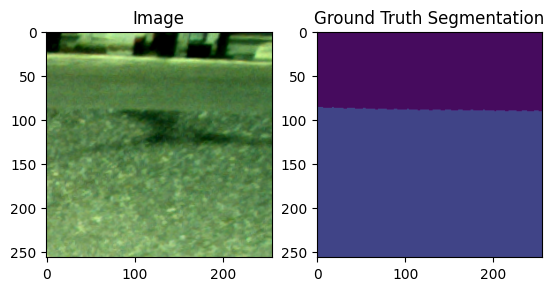

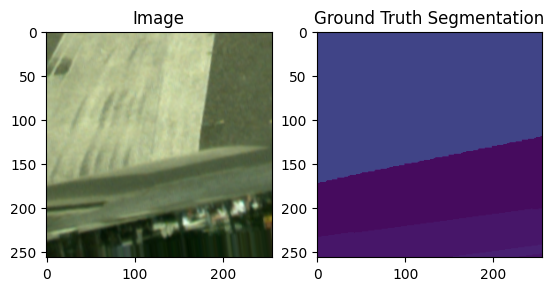

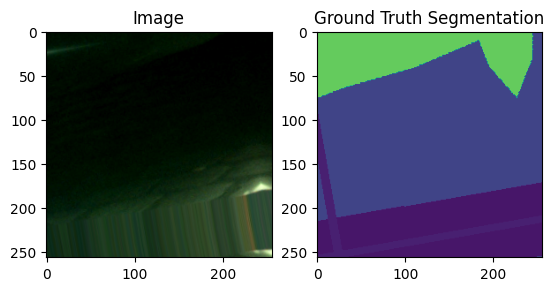

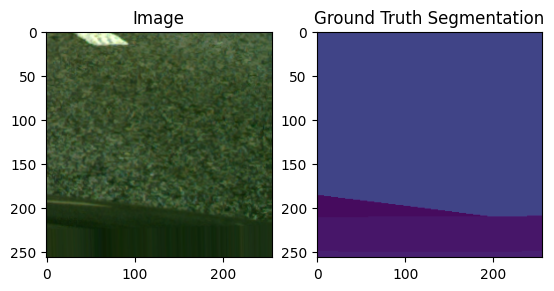

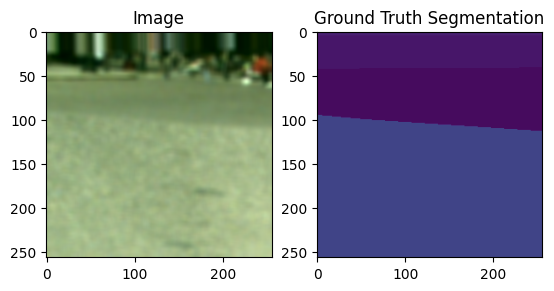

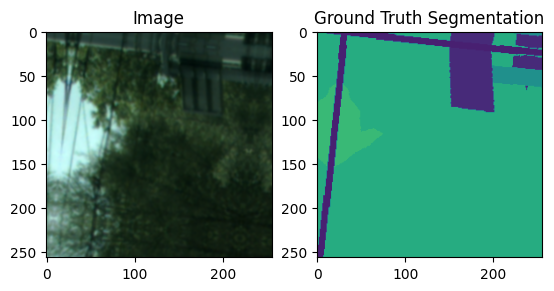

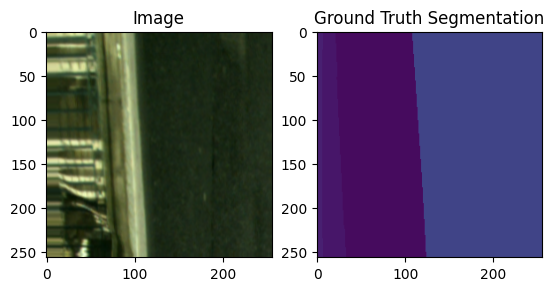

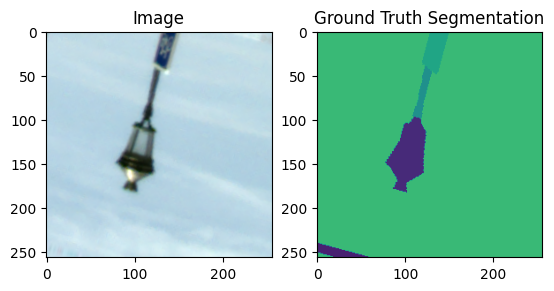

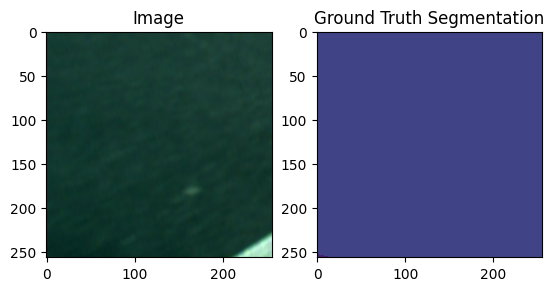

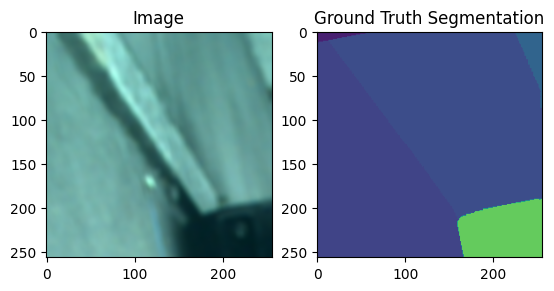

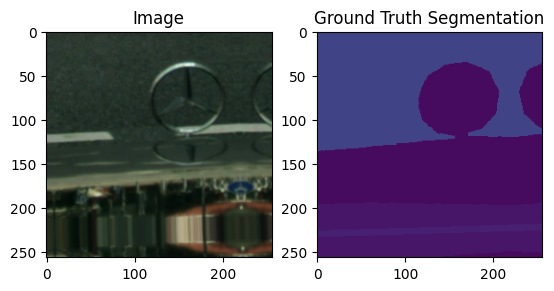

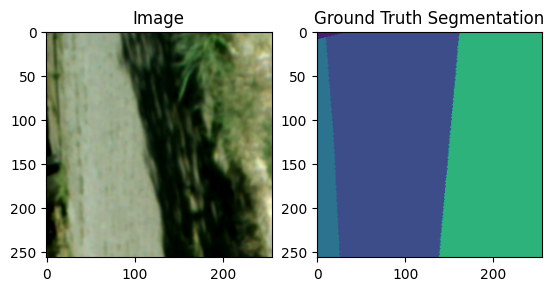

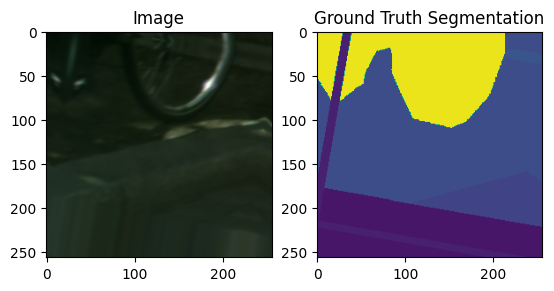

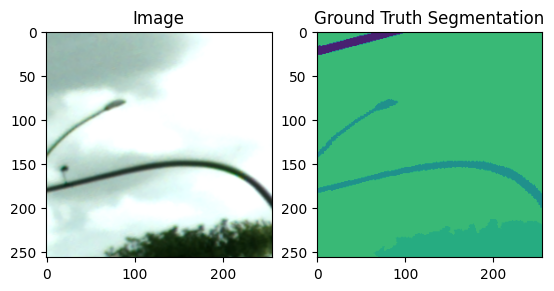

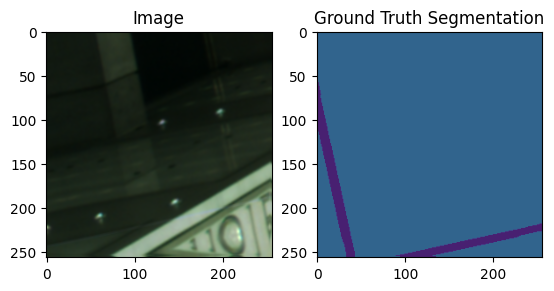

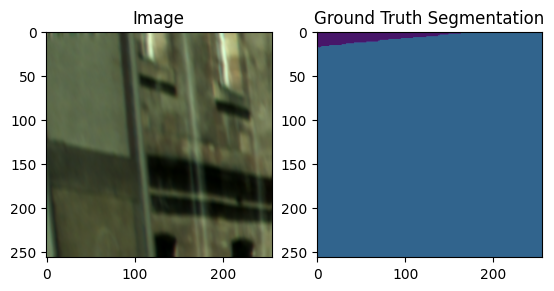

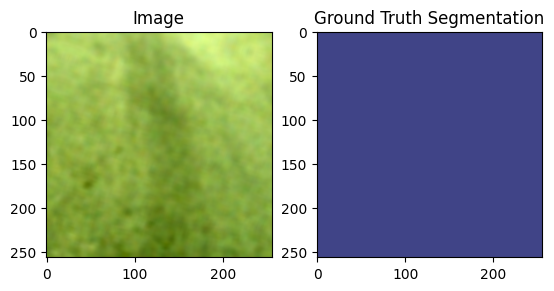

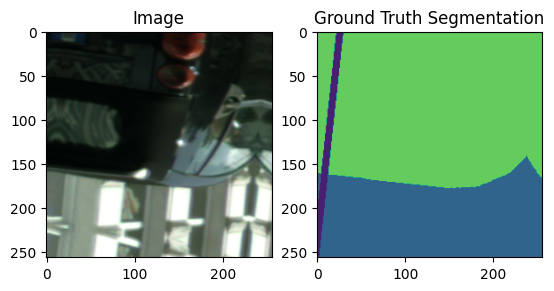

In [28]:
batch = train_data_gen.__next__()
display_batch_of_images(batch)

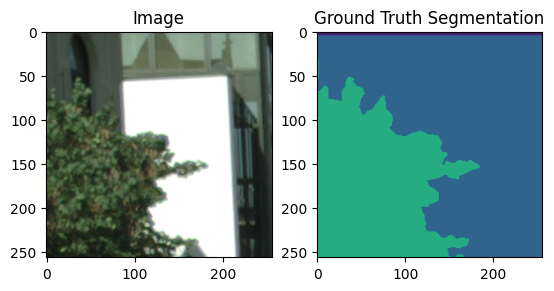

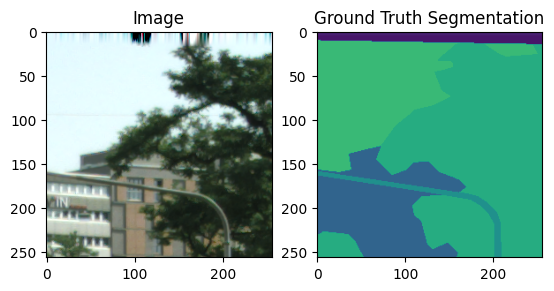

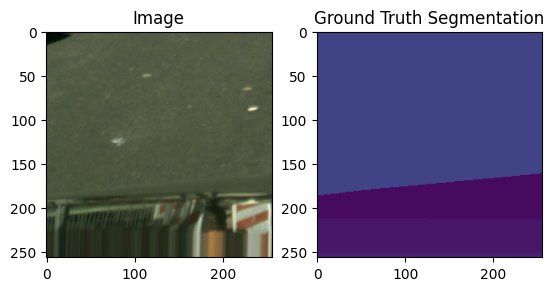

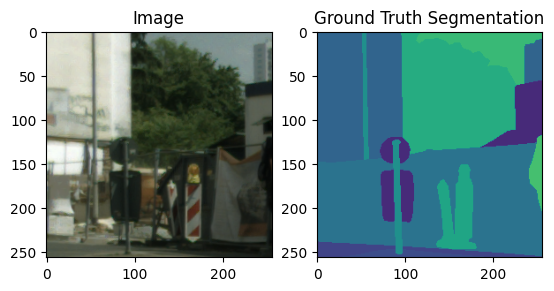

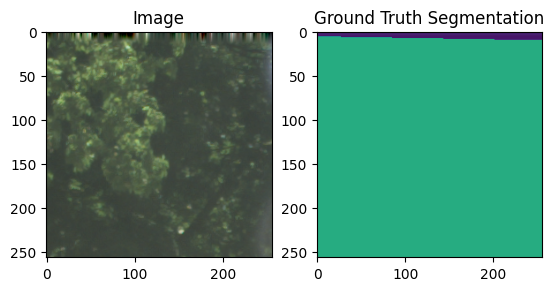

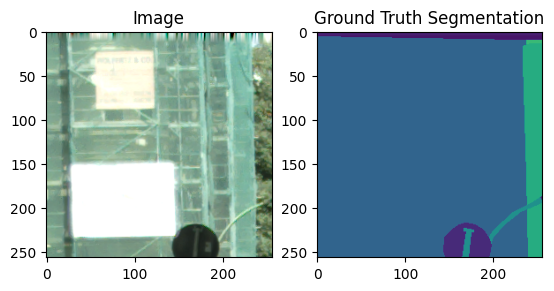

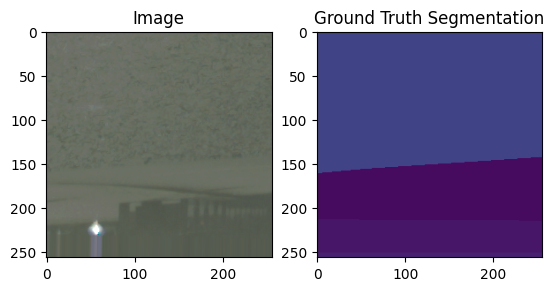

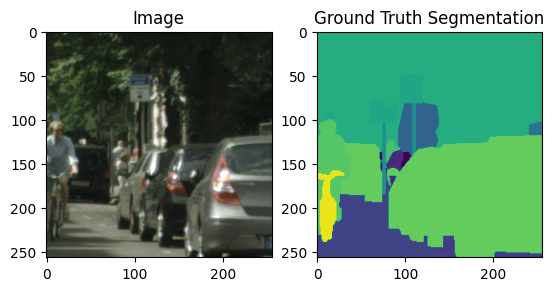

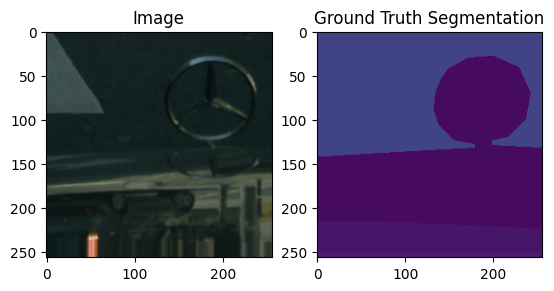

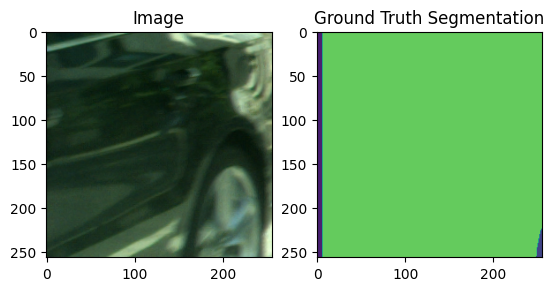

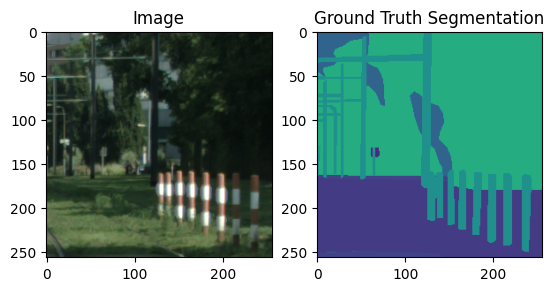

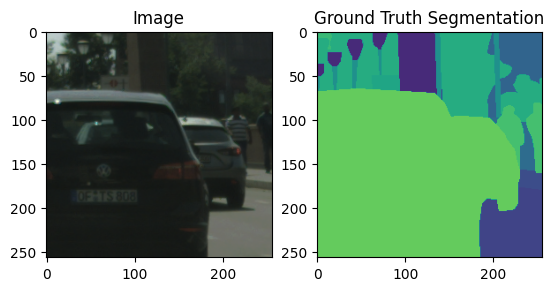

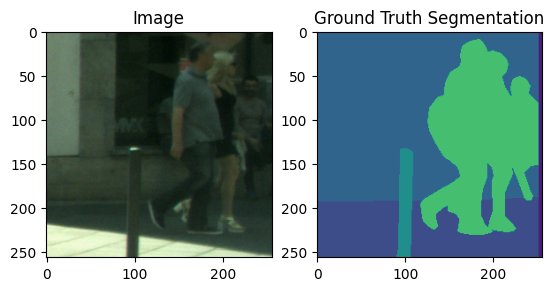

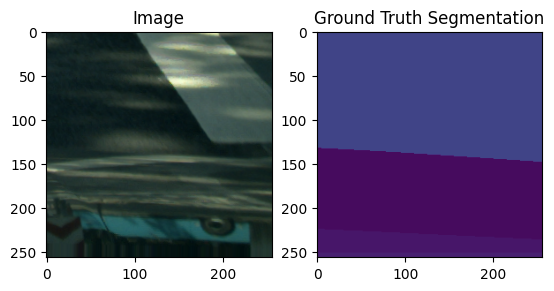

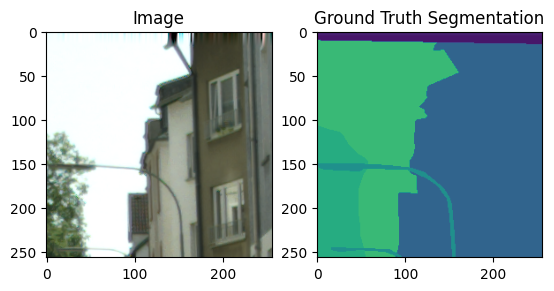

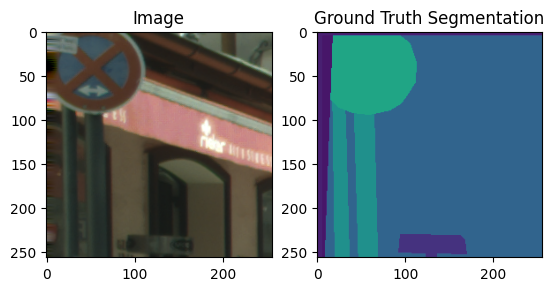

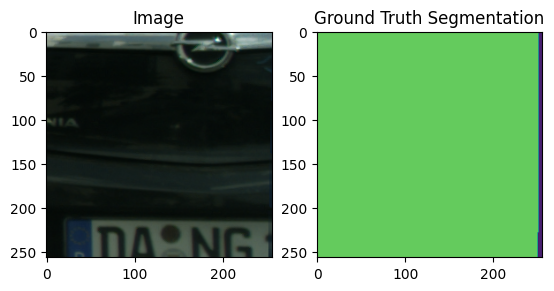

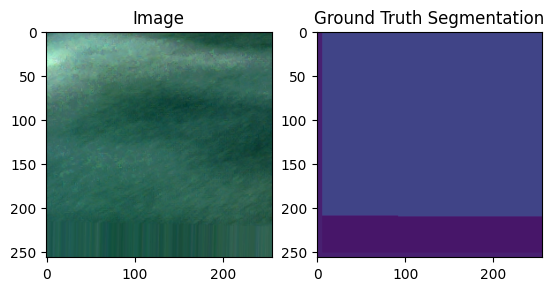

In [9]:
batch = val_data_gen.__next__()
display_batch_of_images(batch)

# Define Model

In [10]:
def fcn_simple_no_border(input_height:int, input_width:int, input_channels:int, num_classes:int) -> tf.keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = tf.keras.Sequential()
    
    # (used to define input shape on the first layers)
    model.add(tf.keras.layers.Layer(input_shape=(input_height , input_width, input_channels)))
    
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))

    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))

    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=1, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=1, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=1, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=1, strides=1, padding='same', activation='relu'))
    
    model.add(tf.keras.layers.Convolution2D(filters=num_classes, kernel_size=3, strides=(1, 1), padding='same', activation='softmax'))
    
    return model

In [11]:
#model = fcn_simple_no_border(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2], NUM_CLASSES)

In [12]:
from unet import build_unet

model = build_unet(NUM_CLASSES, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2] )

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Calculate Class weights for loss

In [14]:
#tf.keras.utils.plot_model(model)

In [8]:
x, y = train_data_gen.__next__()

print(x.shape)
print(y.shape)

(18, 256, 256, 3)
(18, 256, 256, 34)


In [9]:
_, y = train_data_gen.__next__()

total_values = y.shape[1] * y.shape[2] * y.shape[3]

class_counts = np.zeros(NUM_CLASSES)

n = 5

for _ in range(n):

    _, y = train_data_gen.__next__()

    #undo keras.to_categorical
    y = np.argmax(y, axis=-1)

    indexes = np.unique(y, return_counts=True)[0]
    counts = np.unique(y, return_counts=True)[1]
    for index, count in zip(indexes, counts):
        class_counts[index-1] += count

    
class_weights = np.asarray(class_counts)
class_weights = np.divide(class_weights, total_values*n)
class_weights = np.sum(class_weights) - class_weights
class_weights = np.divide(class_weights, np.sum(class_weights))
    
print(f"Class weights: {class_weights}")
print(np.sum(class_weights))

Class weights: [0.02827627 0.029024   0.02983875 0.02995079 0.03028599 0.02978693
 0.01962276 0.0277229  0.03012128 0.03022372 0.02618636 0.03025748
 0.02977189 0.03030303 0.02978479 0.03030303 0.03006144 0.03030303
 0.03025451 0.0301841  0.02699735 0.0301615  0.02953378 0.02988423
 0.03025124 0.02859819 0.03030303 0.03030303 0.03030303 0.03029475
 0.03030303 0.03028374 0.03021704 0.03030303]
0.9999999999999999


In [31]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [32]:
LEARNING_RATE = 0.001
STEPS_PER_EPOCH = len(train_data) // BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=STEPS_PER_EPOCH * 4,
    decay_rate=0.95)

In [33]:
!set WANDB_NOTEBOOK_NAME = "01_simple_model.ipynb"

In [34]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="TSM-CompVis-Segmentation",

    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "Adam",
        "learning_rate": f"{LEARNING_RATE}",
        "loss": "total_loss",
        "batch_size": BATCH_SIZE,
        "steps_per_epoch": STEPS_PER_EPOCH,
        "metric": "Accuracy, F1, Dice"
    }
)


In [35]:
MODEL_NAME = wandb.run.name

In [36]:
# Define callbacks.

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "training/"+MODEL_NAME+"/checkpoints/epoch_{epoch}_val_loss_{val_loss}.keras",
    monitor='val_loss',
    save_best_only=True
)

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=f"training/{MODEL_NAME}/tensorboard",
    histogram_freq=1,
    write_graph=True
)

In [37]:
metrics = [
        tf.keras.metrics.CategoricalAccuracy(),
    ]

loss = tf.keras.losses.CategoricalCrossentropy()


optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
)


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [38]:
print(f"Run Name: {MODEL_NAME}")

Run Name: autumn-elevator-65


In [39]:


history = model.fit(x=train_data_gen, validation_data=val_data_gen, validation_steps=(len(val_data) // (BATCH_SIZE*2)), validation_batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, batch_size=BATCH_SIZE, epochs=800, callbacks=[checkpoint_cb, WandbMetricsLogger(log_freq=200)])

Epoch 1/800
1306/1306 [==============================] - 290s 220ms/step - loss: 0.7791 - categorical_accuracy: 0.7959 - val_loss: 0.8662 - val_categorical_accuracy: 0.7754


c:\Users\cyril\.conda\envs\tensorflow_gpu\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/800
1306/1306 [==============================] - 303s 232ms/step - loss: 0.7904 - categorical_accuracy: 0.7946 - val_loss: 0.8179 - val_categorical_accuracy: 0.7926
Epoch 3/800
1306/1306 [==============================] - 291s 223ms/step - loss: 0.8018 - categorical_accuracy: 0.7922 - val_loss: 0.7279 - val_categorical_accuracy: 0.8135
Epoch 4/800
1306/1306 [==============================] - 280s 214ms/step - loss: 0.7978 - categorical_accuracy: 0.7938 - val_loss: 0.8199 - val_categorical_accuracy: 0.7853
Epoch 5/800
1306/1306 [==============================] - 271s 207ms/step - loss: 0.7994 - categorical_accuracy: 0.7937 - val_loss: 0.7110 - val_categorical_accuracy: 0.8201
Epoch 6/800
1306/1306 [==============================] - 271s 207ms/step - loss: 0.8015 - categorical_accuracy: 0.7930 - val_loss: 0.7812 - val_categorical_accuracy: 0.7911
Epoch 7/800
1306/1306 [==============================] - 270s 207ms/step - loss: 0.7936 - categorical_accuracy: 0.7955 - val_loss: 0.78

KeyboardInterrupt: 

# Calculate Performance

In [41]:
model = tf.keras.models.load_model(f"training/autumn-elevator-65/checkpoints/epoch_179_val_loss_0.5163795351982117.keras", compile=False)

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [43]:
iou_score = sm.metrics.IOUScore()

f_score = sm.metrics.FScore()

# Train data

In [44]:
train_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/train/train2/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/train/train2/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE * 10,
    augmentation = False
)
train_data_gen = train_data.get_data_generator()



Indexing Image files...
Indexing Segmentation files...
Loaded 23520 images with 23520 segmentations


In [45]:
import pandas as pd
from tqdm import tqdm

class_index = 1

IoU_df = pd.DataFrame()
FScore_df = pd.DataFrame()
Accuracy_df = pd.DataFrame()

predicted_fscores = []
predicted_ious = []
predicted_accuracies = []

for _ in tqdm(range(len(train_data) // (BATCH_SIZE * 10))):

    x, ground_truth = train_data_gen.__next__()
    
    predicted = model.predict(x)
    #predicted = ground_truth
    

    # ----- calc IoU -----
    iou_predicted = iou_score.__call__(ground_truth, predicted)
    predicted_ious.append(iou_predicted.numpy())

    # ----- calc FScore -----
    fscore_predicted = f_score.__call__(ground_truth, predicted)
    predicted_fscores.append(fscore_predicted.numpy())

    # ----- calc Accuracy -----
    m = tf.keras.metrics.CategoricalAccuracy()
    m.update_state(ground_truth, predicted)
    predicted_accuracies.append(m.result().numpy())
    
FScore_df[f'FScore'] = predicted_fscores
IoU_df[f'IoU'] = predicted_ious
Accuracy_df[f'Accuracy'] = predicted_accuracies

    
# add the two score dataframes horizontally
metrics_df = pd.concat([FScore_df, IoU_df, Accuracy_df], axis=1)

100%|██████████| 130/130 [06:42<00:00,  3.09s/it]


In [46]:
metrics_df.describe()

FScore         IoU    Accuracy
count  130.000000  130.000000  130.000000
mean     0.414264    0.332495    0.897913
std      0.021827    0.017215    0.009678
min      0.353962    0.287643    0.874729
25%      0.399114    0.321257    0.891209
50%      0.414115    0.331224    0.897991
75%      0.428073    0.342137    0.904406
max      0.495504    0.396390    0.919362

# Val data

In [47]:
val_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/val/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/val/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE * 10,
    augmentation = False
)
val_data_gen = val_data.get_data_generator()

Indexing Image files...
Indexing Segmentation files...
Loaded 8544 images with 8544 segmentations


In [48]:
import pandas as pd
from tqdm import tqdm

class_index = 1

IoU_df = pd.DataFrame()
FScore_df = pd.DataFrame()
Accuracy_df = pd.DataFrame()

predicted_fscores = []
predicted_ious = []
predicted_accuracies = []

for _ in tqdm(range(len(val_data) // (BATCH_SIZE * 10))):

    x, ground_truth = val_data_gen.__next__()
    
    predicted = model.predict(x)
    #predicted = ground_truth
    

    # ----- calc IoU -----
    iou_predicted = iou_score.__call__(ground_truth, predicted)
    predicted_ious.append(iou_predicted.numpy())

    # ----- calc FScore -----
    fscore_predicted = f_score.__call__(ground_truth, predicted)
    predicted_fscores.append(fscore_predicted.numpy())

    # ----- calc Accuracy -----
    m = tf.keras.metrics.CategoricalAccuracy()
    m.update_state(ground_truth, predicted)
    predicted_accuracies.append(m.result().numpy())
    
FScore_df[f'FScore'] = predicted_fscores
IoU_df[f'IoU'] = predicted_ious
Accuracy_df[f'Accuracy'] = predicted_accuracies

    
# add the two score dataframes horizontally
metrics_df = pd.concat([FScore_df, IoU_df, Accuracy_df], axis=1)

100%|██████████| 47/47 [02:26<00:00,  3.12s/it]


In [49]:
metrics_df.describe()

FScore        IoU   Accuracy
count  47.000000  47.000000  47.000000
mean    0.330489   0.263915   0.859529
std     0.011199   0.009396   0.013740
min     0.301107   0.242201   0.828114
25%     0.323073   0.258740   0.848265
50%     0.330723   0.264539   0.860878
75%     0.339054   0.271185   0.870674
max     0.348996   0.282250   0.883893

# Test data

In [50]:
test_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/test/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/test/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE * 10,
    augmentation = False
)
test_data_gen = test_data.get_data_generator()

Indexing Image files...
Indexing Segmentation files...
Loaded 1888 images with 1888 segmentations


In [51]:
import pandas as pd
from tqdm import tqdm

class_index = 1

IoU_df = pd.DataFrame()
FScore_df = pd.DataFrame()
Accuracy_df = pd.DataFrame()

predicted_fscores = []
predicted_ious = []
predicted_accuracies = []

for _ in tqdm(range(len(test_data) // (BATCH_SIZE * 10))):

    x, ground_truth = test_data_gen.__next__()
    
    predicted = model.predict(x)
    #predicted = ground_truth
    

    # ----- calc IoU -----
    iou_predicted = iou_score.__call__(ground_truth, predicted)
    predicted_ious.append(iou_predicted.numpy())

    # ----- calc FScore -----
    fscore_predicted = f_score.__call__(ground_truth, predicted)
    predicted_fscores.append(fscore_predicted.numpy())

    # ----- calc Accuracy -----
    m = tf.keras.metrics.CategoricalAccuracy()
    m.update_state(ground_truth, predicted)
    predicted_accuracies.append(m.result().numpy())
    
FScore_df[f'FScore'] = predicted_fscores
IoU_df[f'IoU'] = predicted_ious
Accuracy_df[f'Accuracy'] = predicted_accuracies

    
# add the two score dataframes horizontally
metrics_df = pd.concat([FScore_df, IoU_df, Accuracy_df], axis=1)

100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


In [95]:
metrics_df

FScore       IoU  Accuracy
0  0.200322  0.142581  0.695666
1  0.211328  0.150442  0.682157
2  0.175440  0.126439  0.655927
3  0.197279  0.142318  0.665889
4  0.199168  0.140859  0.669912
5  0.179264  0.128246  0.627747
6  0.190417  0.135935  0.692300
7  0.200594  0.144135  0.683633
8  0.185329  0.133341  0.663251
9  0.185098  0.133169  0.678369

In [52]:
metrics_df.describe()

FScore        IoU   Accuracy
count  10.000000  10.000000  10.000000
mean    0.214698   0.155966   0.686573
std     0.014949   0.012580   0.024465
min     0.201068   0.142520   0.655856
25%     0.205552   0.146631   0.666222
50%     0.211397   0.154810   0.689654
75%     0.215196   0.158643   0.694173
max     0.250587   0.183966   0.734076

In [41]:
i = 1

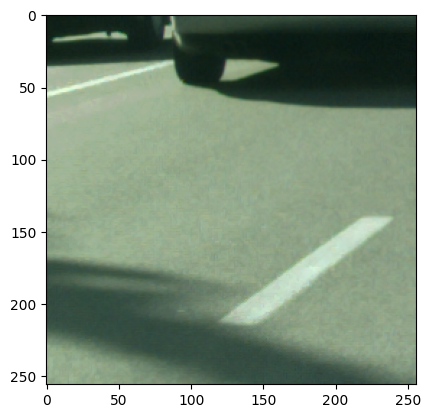

In [42]:
plt.imshow(x[i,:,:])

In [43]:
np.argmax(y, axis=-1)[0]

array([[21, 21, 21, ..., 17, 17, 17],
       [21, 21, 21, ..., 17, 17, 17],
       [21, 21, 21, ..., 17, 17, 17],
       ...,
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21]], dtype=int64)

In [45]:
y.shape

(18, 256, 256, 34)

In [46]:
np.argmax(y, axis=-1).shape

(18, 256, 256)

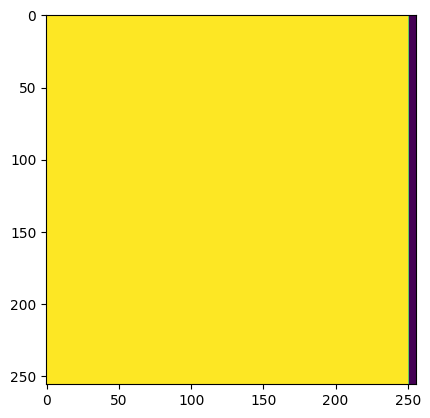

In [47]:

plt.imshow(np.argmax(y, axis=-1)[i])

In [32]:
y_pred = model.predict(x)

Text(0.5, 1.0, 'Predicted')

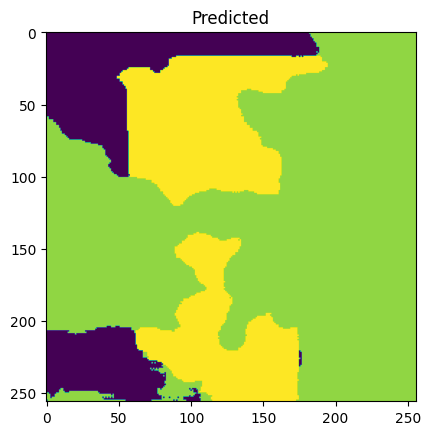

In [33]:
seg = y_pred[i]


#undo keras.to_categorical
seg = np.argmax(seg, axis=-1)

plt.imshow(seg)
plt.title('Predicted')

In [ ]:
seg

array([[14, 27, 27, ..., 27, 27, 24],
       [28, 27, 27, ..., 27, 24, 26],
       [28, 27, 27, ..., 27, 27, 10],
       ...,
       [ 8, 27,  8, ...,  8, 26, 26],
       [ 8,  8,  8, ...,  8,  8,  8],
       [ 8, 26,  8, ...,  8, 26, 26]], dtype=int64)

Text(0.5, 1.0, 'GT')

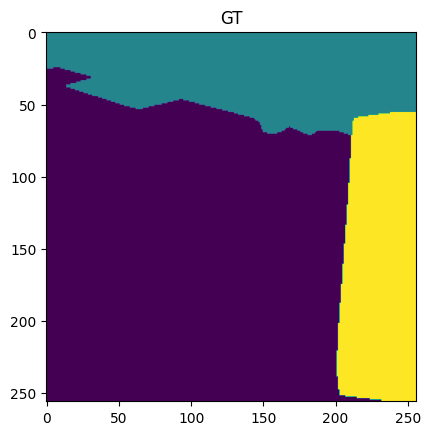

In [ ]:
seg = y[0]


#undo keras.to_categorical
seg = np.argmax(seg, axis=-1)

plt.imshow(seg)
plt.title('GT')

In [ ]:
seg

array([[21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       ...,
       [20, 20, 20, ...,  8,  8,  8],
       [20, 20, 20, ...,  8,  8,  8],
       [20, 20, 20, ...,  8,  8,  8]], dtype=int64)

In [48]:
test_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/test/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/test/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = False
)
test_data_gen = test_data.get_data_generator()

Indexing Image files...
Indexing Segmentation files...
Loaded 1888 images with 1888 segmentations


In [49]:
x, y = val_data_gen.__next__()
y_pred = model.predict(x)

In [62]:
i = 0

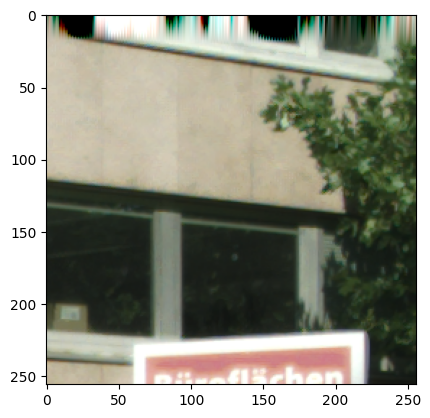

In [63]:
plt.imshow(x[i,:,:])

In [67]:
y_pred[i]

array([[[2.37924120e-04, 2.60944702e-02, 1.73568726e-01, ...,
         9.08670423e-04, 7.29276391e-04, 4.58638743e-03],
        [6.41004590e-05, 2.11885870e-02, 2.36742929e-01, ...,
         3.79066740e-04, 2.37813263e-04, 1.55458332e-03],
        [2.10100570e-05, 1.89635996e-02, 2.48808801e-01, ...,
         1.73576627e-04, 4.41281118e-05, 2.72157398e-04],
        ...,
        [6.33898389e-06, 2.08904594e-03, 1.92259073e-01, ...,
         4.80579547e-05, 4.18057698e-06, 1.62452343e-05],
        [1.74945671e-05, 3.08902655e-03, 1.92678452e-01, ...,
         1.33137932e-04, 1.17306208e-05, 4.36500195e-05],
        [1.66208425e-04, 9.02974792e-03, 2.86121905e-01, ...,
         1.48226309e-03, 7.78151662e-05, 3.47475841e-04]],

       [[1.10291243e-04, 1.60376430e-02, 2.31892943e-01, ...,
         5.52766258e-04, 3.83025821e-04, 2.48698704e-03],
        [1.91299205e-05, 7.27373874e-03, 1.67130619e-01, ...,
         1.72370041e-04, 6.65568805e-05, 3.92284535e-04],
        [9.92745845e-06, 

Text(0.5, 1.0, 'Predicted')

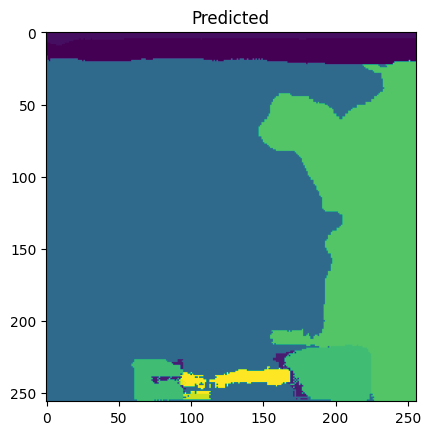

In [64]:
seg = y_pred[i]


#undo keras.to_categorical
seg = np.argmax(seg, axis=-1)

plt.imshow(seg)
plt.title('Predicted')

Text(0.5, 1.0, 'GT')

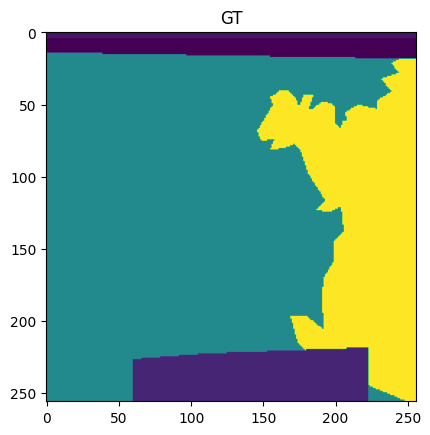

In [65]:
seg = y[i]


#undo keras.to_categorical
seg = np.argmax(seg, axis=-1)

plt.imshow(seg)
plt.title('GT')